# Seasonal Naive Approach

Benchmark model that simply forecasts the same value from the previous seasonal period.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../_datasets/daily-exchange-rates.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(7588, 8)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8
DateTime,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


## Define Parameters

Make predictions for 24-hour period using a seasonality of 24-hours.

In [4]:
dataset_name = 'Daily Exchange Rates'
dataset_abbr = 'DER'
model_name = 'Naive'
context_length = 52*5 # 52 weeks
prediction_length = 4*5 # four weeks

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [5]:
def calc_MASE(training_series, testing_series, prediction_series):
    a = training_series.iloc[1:].values
    b = training_series.iloc[:-1].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Evaluate Naive Model

In [6]:
results = df.copy()
for i, col in enumerate(df.columns):
    results['pred%s' % str(i+1)] = results[col].iloc[-(1+prediction_length)]
results.dropna(inplace=True)

In [7]:
MASEs = []
for i, col in enumerate(df.columns):
    MASEs.append(calc_MASE(results[col].iloc[-(context_length + prediction_length):-prediction_length],
                           results[col].iloc[-prediction_length:],
                           results['pred%s' % str(i+1)].iloc[-prediction_length:]))

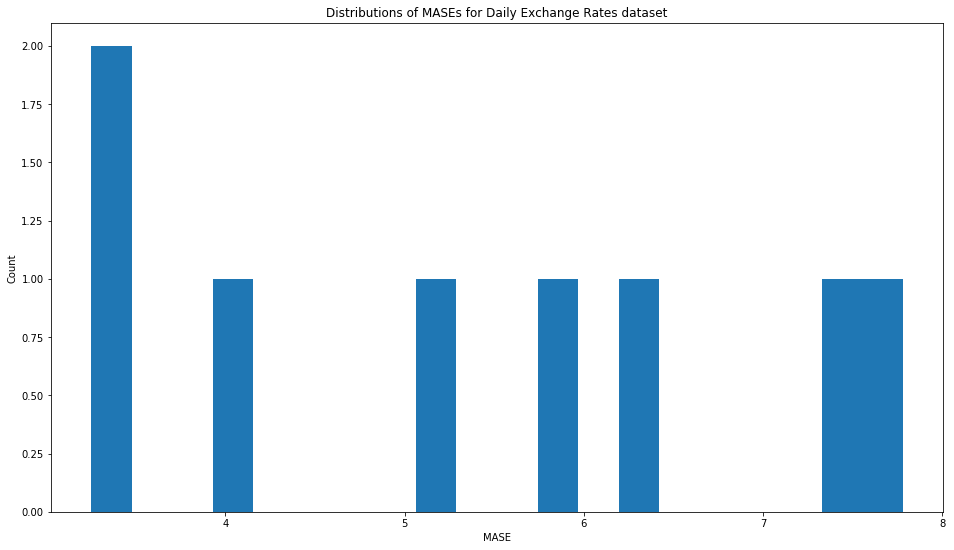

In [8]:
fig, ax = plt.subplots()
ax.hist(MASEs, bins=20)
ax.set_title('Distributions of MASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('MASE')
ax.set_ylabel('Count');

In [9]:
MASE = np.mean(MASEs)
print("Overall MASE: {:.4f}".format(MASE))

Overall MASE: 5.4277


Show some example forecasts.

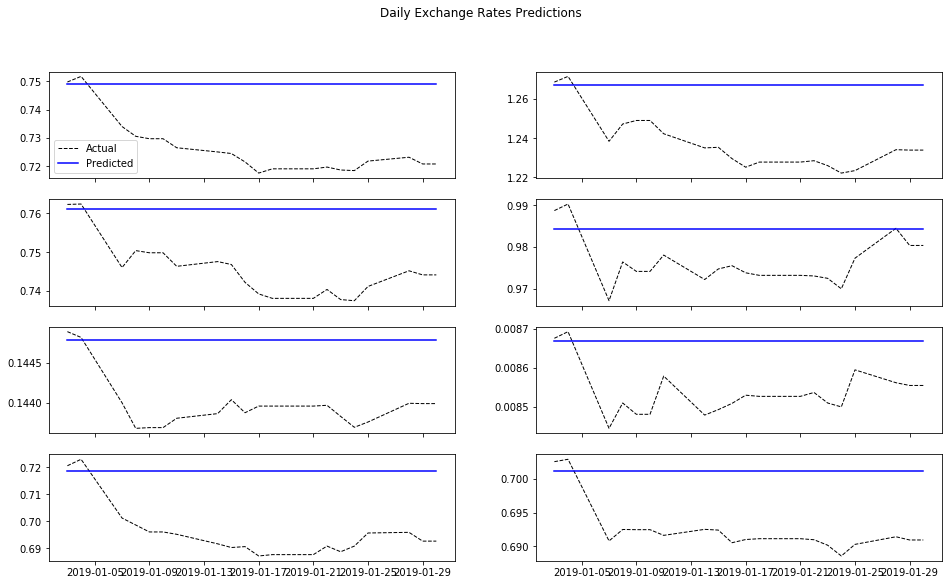

In [10]:
fig, ax = plt.subplots(4, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 9):
    ax[col-1].plot(results.index[-prediction_length:], results['ts%s' % col].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results.index[-prediction_length:], results['pred%s' % col].iloc[-prediction_length:],
                   label='Predicted', c='b')
fig.suptitle('{} Predictions'.format(dataset_name))
ax[0].legend();

Store the predictions and accuracy score for the Seasonal Naive Approach models.

In [11]:
import pickle
    
with open('{}-MASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(MASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)